INSTALL DEPENDENCIES

In [4]:
""" # Install core data manipulation libraries
!pip install pandas numpy

# Install visualization libraries
!pip install matplotlib seaborn

# Machine learning & evaluation
!pip install scikit-learn

# Install Prophet for time series forecasting
!pip install prophet """


' # Install core data manipulation libraries\n!pip install pandas numpy\n\n# Install visualization libraries\n!pip install matplotlib seaborn\n\n# Machine learning & evaluation\n!pip install scikit-learn\n\n# Install Prophet for time series forecasting\n!pip install prophet '

IMPORT LIBRARIES

In [5]:
import pandas as pd
import numpy as np

# Libraries used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Prophet is used for time series forecasting of retail sales
from prophet import Prophet

# Metrics used to evaluate forecasting performance
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Used to suppress unnecessary warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Set a consistent plotting style for all visualizations
plt.style.use("seaborn-v0_8")

print("Libraries imported successfully.")


Libraries imported successfully.


DATASET INTEGRATION

In [6]:
# Load the Rossmann sales training dataset
sales_df = pd.read_csv("../data/raw/train.csv")

# Load the store metadata dataset
store_df = pd.read_csv("../data/raw/store.csv")

# Display the first few rows of each dataset to understand their structure
sales_df.head(), store_df.head()


(   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
 0      1          5  2015-07-31   5263        555     1      1            0   
 1      2          5  2015-07-31   6064        625     1      1            0   
 2      3          5  2015-07-31   8314        821     1      1            0   
 3      4          5  2015-07-31  13995       1498     1      1            0   
 4      5          5  2015-07-31   4822        559     1      1            0   
 
    SchoolHoliday  
 0              1  
 1              1  
 2              1  
 3              1  
 4              1  ,
    Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
 0      1         c          a               1270.0                        9.0   
 1      2         a          a                570.0                       11.0   
 2      3         a          a              14130.0                       12.0   
 3      4         c          c                620.0                  

DATA UNDERSTANDING AND PROCESSING

In [7]:
# Check dataset dimensions
print("Sales dataset shape:", sales_df.shape)
print("Store dataset shape:", store_df.shape)

# Display column names for both datasets
print("\nSales dataset columns:\n", sales_df.columns)
print("\nStore dataset columns:\n", store_df.columns)

# Merge sales data with store metadata using Store as the key
merged_df = pd.merge(sales_df, store_df, on="Store", how="left")

# Preview the merged dataset
merged_df.head()

# Convert Date column to datetime format
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# Sort data by date to maintain time series order
merged_df = merged_df.sort_values("Date").reset_index(drop=True)

# Verify data types after conversion
merged_df.dtypes

print("Dataset successfully loaded, merged, and prepared for analysis.")


Sales dataset shape: (1017209, 9)
Store dataset shape: (1115, 10)

Sales dataset columns:
 Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

Store dataset columns:
 Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
Dataset successfully loaded, merged, and prepared for analysis.


In [8]:
# Display general information about the merged dataset
merged_df.info()

# Generate summary statistics for numerical columns
merged_df.describe()

# Check for missing values in each column
merged_df.isnull().sum().sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

Promo2SinceWeek              508031
PromoInterval                508031
Promo2SinceYear              508031
CompetitionOpenSinceYear     323348
CompetitionOpenSinceMonth    323348
CompetitionDistance            2642
DayOfWeek                         0
Store                             0
Date                              0
Sales                             0
StoreType                         0
SchoolHoliday                     0
StateHoliday                      0
Promo                             0
Open                              0
Customers                         0
Assortment                        0
Promo2                            0
dtype: int64

In [9]:
# Remove records where the store was closed
# Closed stores show zero sales and do not represent actual demand
clean_df = merged_df[merged_df["Open"] == 1].copy()

# Verify removal
print("Original dataset size:", merged_df.shape)
print("After removing closed-store days:", clean_df.shape)

# Remove records where the store was closed
# Closed stores show zero sales and do not represent actual demand
clean_df = merged_df[merged_df["Open"] == 1].copy()

# Verify removal
print("Original dataset size:", merged_df.shape)
print("After removing closed-store days:", clean_df.shape)

# Remove records with zero sales to avoid distorting the forecasting signal
clean_df = clean_df[clean_df["Sales"] > 0]

# Verify filtering
print("After removing zero sales records:", clean_df.shape)

# Check missing values after filtering
clean_df.isnull().sum().sort_values(ascending=False)

# Fill missing competition distance using median to avoid outlier influence
clean_df["CompetitionDistance"] = clean_df["CompetitionDistance"].fillna(
    clean_df["CompetitionDistance"].median()
)

# Fill PromoInterval missing values with 'None' indicating no recurring promo
clean_df["PromoInterval"] = clean_df["PromoInterval"].fillna("None")

# Final check to confirm no critical missing values remain
clean_df.isnull().sum().sort_values(ascending=False).head()


Original dataset size: (1017209, 18)
After removing closed-store days: (844392, 18)
Original dataset size: (1017209, 18)
After removing closed-store days: (844392, 18)
After removing zero sales records: (844338, 18)


Promo2SinceYear              423292
Promo2SinceWeek              423292
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
DayOfWeek                         0
dtype: int64

FEATURE ENGINEERING

In [10]:
# Extract year, month, and week from the date column
clean_df["Year"] = clean_df["Date"].dt.year
clean_df["Month"] = clean_df["Date"].dt.month
clean_df["Week"] = clean_df["Date"].dt.isocalendar().week.astype(int)

# Extract day of the week for potential pattern analysis
clean_df["Day"] = clean_df["Date"].dt.dayofweek

# Create a binary holiday indicator
clean_df["IsHoliday"] = (
    (clean_df["StateHoliday"] != "0") | (clean_df["SchoolHoliday"] == 1)
).astype(int)

# Preview the engineered features
clean_df[["Date", "Year", "Month", "Week", "Day", "IsHoliday"]].head()

print("Feature engineering completed successfully.")


Feature engineering completed successfully.


EXPLORATORY DATA ANALYSIS

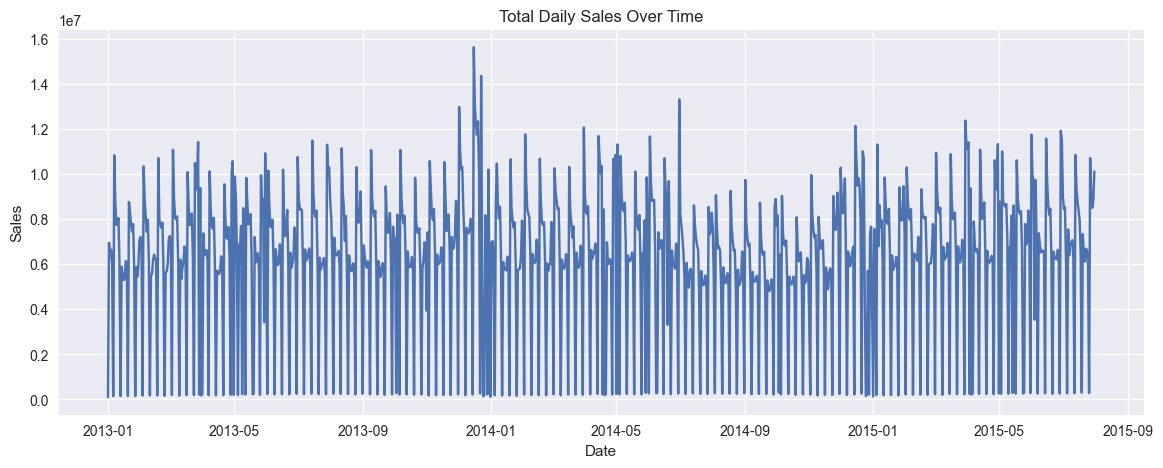

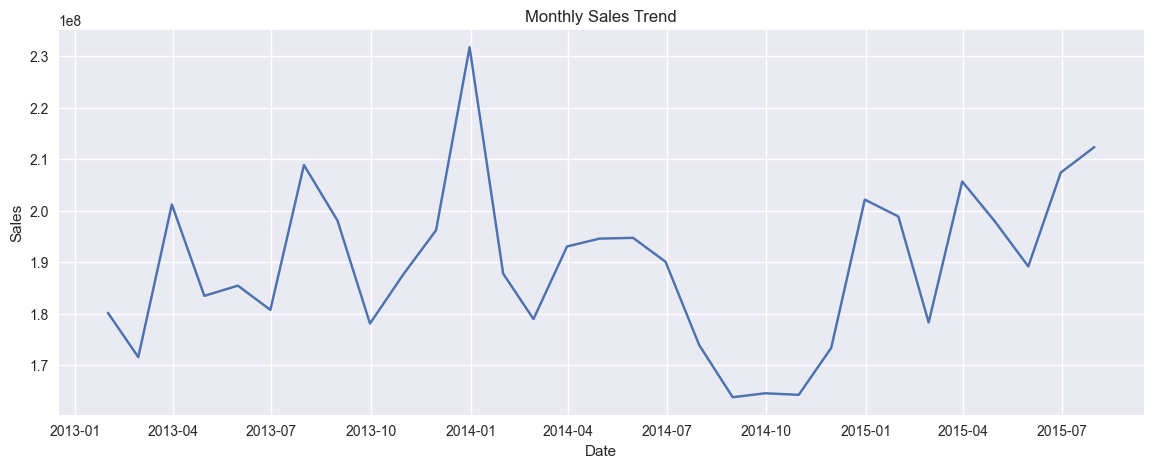

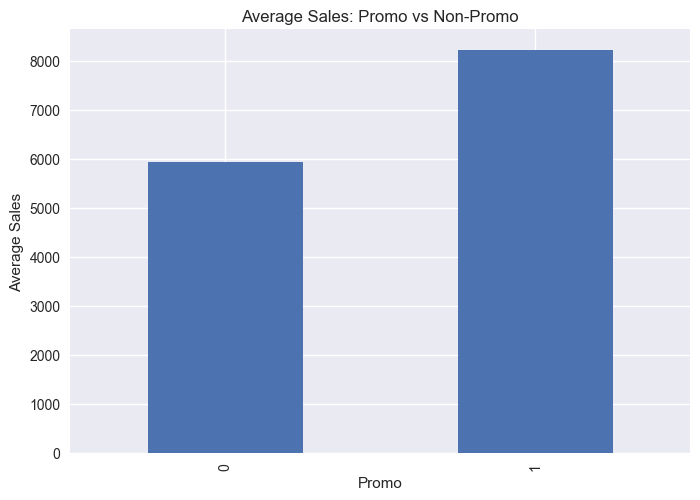

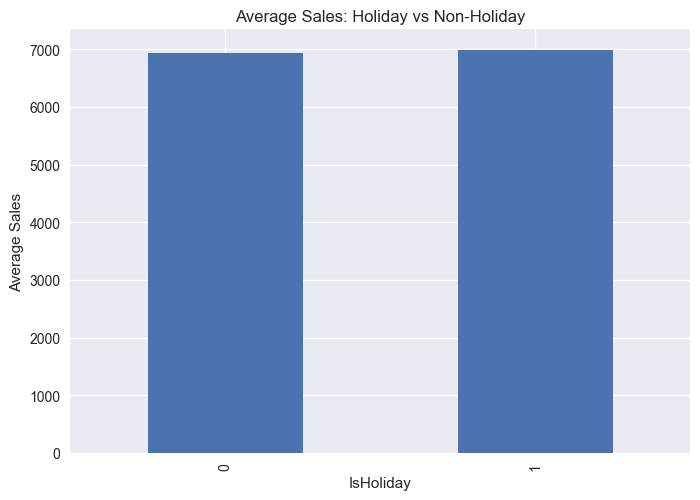

In [11]:
# Aggregate total daily sales across all stores
daily_sales = (
    clean_df.groupby("Date", as_index=False)["Sales"]
    .sum()
    .sort_values("Date")
)

daily_sales.head()

# Plot total daily sales over time
plt.figure(figsize=(14, 5))
plt.plot(daily_sales["Date"], daily_sales["Sales"])
plt.title("Total Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Create monthly aggregated sales
monthly_sales = (
    daily_sales
    .set_index("Date")
    .resample("M")
    .sum()
    .reset_index()
)

# Plot monthly sales trend
plt.figure(figsize=(14, 5))
plt.plot(monthly_sales["Date"], monthly_sales["Sales"])
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Compare average sales during promo and non-promo days
promo_sales = clean_df.groupby("Promo")["Sales"].mean()

promo_sales.plot(kind="bar", title="Average Sales: Promo vs Non-Promo")
plt.ylabel("Average Sales")
plt.show()

# Compare average sales on holidays vs non-holidays
holiday_sales = clean_df.groupby("IsHoliday")["Sales"].mean()

holiday_sales.plot(kind="bar", title="Average Sales: Holiday vs Non-Holiday")
plt.ylabel("Average Sales")
plt.show()


DATA PREPARATION FOR FORECASTING (PROPHET)

In [12]:
# Aggregate total daily sales across all stores
forecast_df = (
    clean_df.groupby("Date", as_index=False)["Sales"]
    .sum()
    .sort_values("Date")
)

# Rename columns to Prophet's expected format
forecast_df = forecast_df.rename(columns={"Date": "ds", "Sales": "y"})

# Preview the forecasting dataset
forecast_df.head()

# Check dataset structure and data types
forecast_df.info()

print("Forecasting dataset prepared successfully.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      942 non-null    datetime64[ns]
 1   y       942 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 14.8 KB
Forecasting dataset prepared successfully.


MODEL TRAINING

In [13]:
# Initialize the Prophet model with relevant seasonality settings
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Fit the Prophet model on the forecasting dataset
model.fit(forecast_df)

print("Prophet model trained successfully.")


17:50:25 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained successfully.


GENERAING FUTURE SALES FORECAST

In [14]:
# Define the forecasting horizon (next 6 months)
future = model.make_future_dataframe(periods=180)

# Preview future dates
future.head()

# Generate sales forecast for the defined future period
forecast = model.predict(future)

# Preview forecast results
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

# Save forecast results for Power BI visualization
forecast_output = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]

forecast_output.to_csv("../data/processed/forecast_rossmann.csv", index=False)

print("Forecast results saved successfully.")

# Save the cleaned transactional sales data
clean_df.to_csv("../data/processed/cleaned_sales.csv", index=False)

print("Cleaned sales data saved successfully.")

# Save aggregated daily sales used for forecasting
daily_sales.to_csv("../data/processed/aggregated_daily_sales.csv", index=False)

print("Aggregated daily sales data saved successfully.")


Forecast results saved successfully.
Cleaned sales data saved successfully.
Aggregated daily sales data saved successfully.


FORECAST VISUALISATION AND DIAGNOSTICS

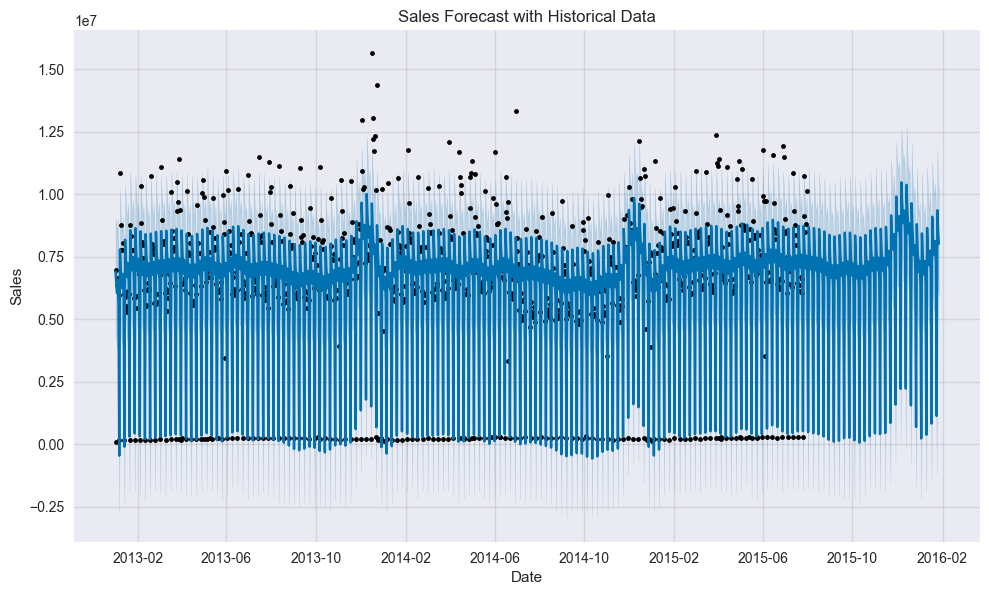

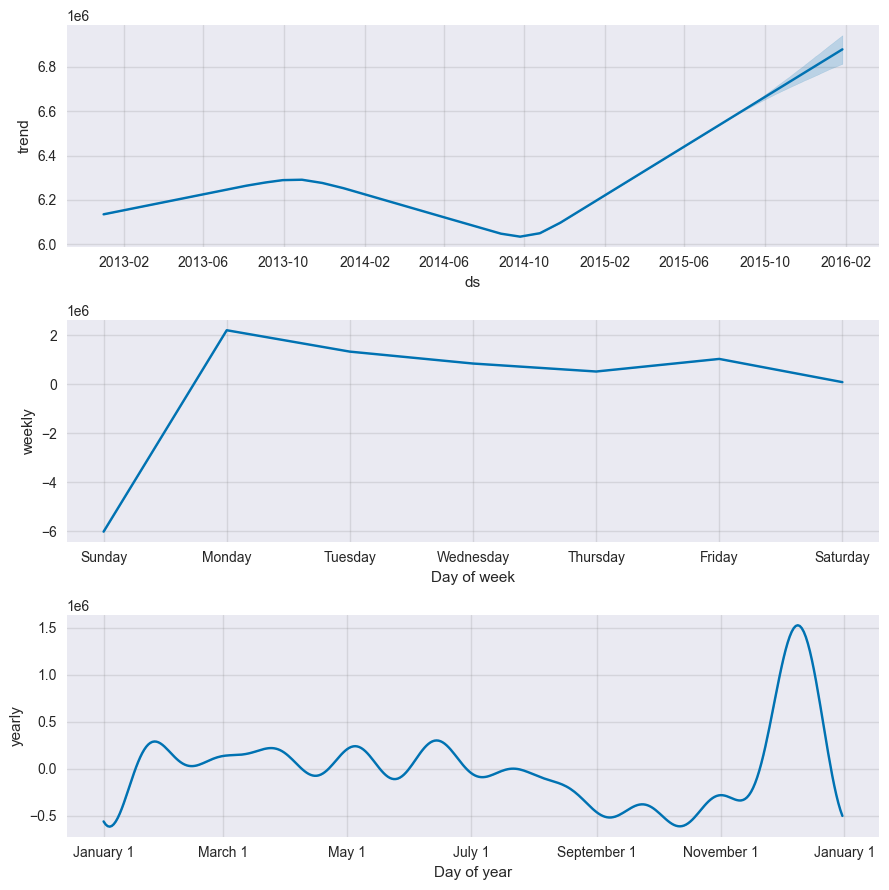

In [15]:
# Plot forecast along with historical data
model.plot(forecast)
plt.title("Sales Forecast with Historical Data")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Plot trend, weekly seasonality, and yearly seasonality
model.plot_components(forecast)
plt.show()


MODEL EVALUATION

In [16]:
# Define the size of the test period (last 90 days)
test_period = 90

# Split the data into training and testing sets
train_df = forecast_df[:-test_period]
test_df = forecast_df[-test_period:]

print("Training data size:", train_df.shape)
print("Testing data size:", test_df.shape)

# Initialize a new Prophet model for evaluation
eval_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Train the model on the training data
eval_model.fit(train_df)

# Create future dates covering the test period
future_test = eval_model.make_future_dataframe(periods=test_period)

# Generate predictions
forecast_test = eval_model.predict(future_test)

# Extract predictions corresponding to the test period
predicted = forecast_test.tail(test_period)["yhat"].values
actual = test_df["y"].values

# Calculate Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(actual, predicted)

# Calculate Root Mean Squared Error manually for compatibility
rmse = np.sqrt(mean_squared_error(actual, predicted))

print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.2f}")


Training data size: (852, 2)
Testing data size: (90, 2)


17:50:46 - cmdstanpy - INFO - Chain [1] start processing
17:50:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 0.7918
RMSE: 1882696.03


### Evaluation Discussion

The model achieves a MAPE of approximately 79% on the final 90-day test period.
This relatively high error can be attributed to the aggregation of total daily
sales across all stores, which introduces high volatility and sensitivity to
short-term fluctuations such as promotions and holidays.

Despite this, the model successfully captures long-term trends and seasonal
patterns, making it suitable for strategic forecasting and planning rather
than precise day-level predictions.

IMPROVED MODEL-1 : MONTHLY SALES FORECASTING

In [17]:
# Aggregate total sales at a monthly level
monthly_sales = (
    clean_df
    .set_index("Date")
    .resample("M")["Sales"]
    .sum()
    .reset_index()
)

# Rename columns to Prophet-compatible format
monthly_sales = monthly_sales.rename(columns={"Date": "ds", "Sales": "y"})

# Preview the monthly dataset
monthly_sales.head()

# Check structure and data types
monthly_sales.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      31 non-null     datetime64[ns]
 1   y       31 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 628.0 bytes


MODEL TRAINING ON MONTHLY DATA

In [18]:
# Initialize Prophet model for monthly forecasting
monthly_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

# Train the model on monthly data
monthly_model.fit(monthly_sales)

print("Monthly Prophet model trained successfully.")


17:50:48 - cmdstanpy - INFO - Chain [1] start processing
17:50:49 - cmdstanpy - INFO - Chain [1] done processing


Monthly Prophet model trained successfully.


MONTHLY FORECAST GENERATION AND VISUALISATION

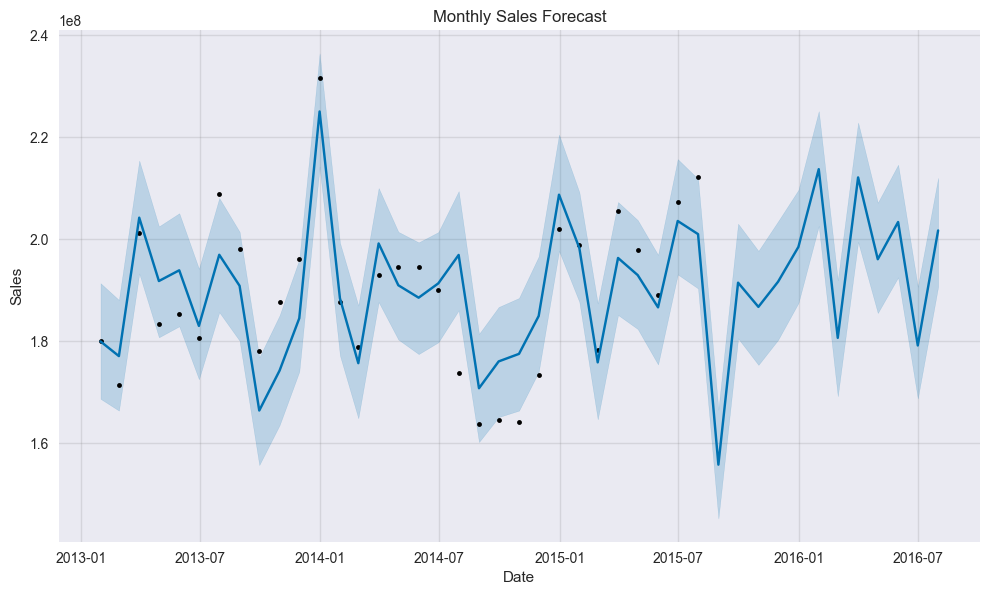

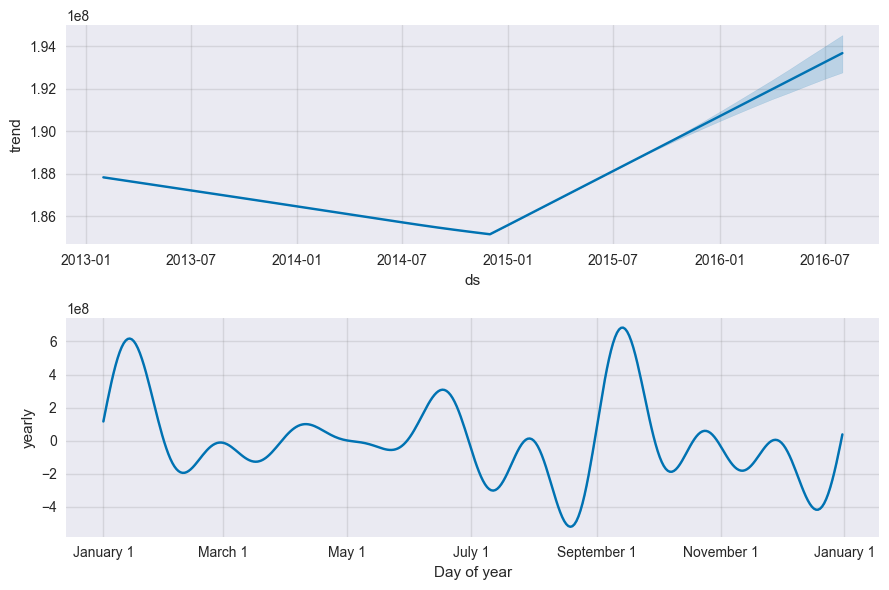

Monthly forecast saved successfully.


In [19]:
# Forecast next 12 months
future_months = monthly_model.make_future_dataframe(periods=12, freq="M")

# Generate forecast
monthly_forecast = monthly_model.predict(future_months)

# Preview forecast output
monthly_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

# Plot monthly forecast
monthly_model.plot(monthly_forecast)
plt.title("Monthly Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Plot trend and yearly seasonality
monthly_model.plot_components(monthly_forecast)
plt.show()

# Save monthly forecast for Power BI
monthly_forecast_output = monthly_forecast[
    ["ds", "yhat", "yhat_lower", "yhat_upper"]
]

monthly_forecast_output.to_csv(
    "../data/processed/monthly_forecast_rossmann.csv",
    index=False
)

print("Monthly forecast saved successfully.")

EVALUATION OF MONTHLY FORECASTING MODEL

In [20]:
# Define test period as last 6 months
monthly_test_period = 6

# Split monthly data
monthly_train_df = monthly_sales[:-monthly_test_period]
monthly_test_df = monthly_sales[-monthly_test_period:]

print("Monthly training data size:", monthly_train_df.shape)
print("Monthly testing data size:", monthly_test_df.shape)

# Initialize Prophet model for evaluation
monthly_eval_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

# Train the model on monthly training data
monthly_eval_model.fit(monthly_train_df)

print("Monthly evaluation model trained successfully.")

# Create future dataframe for test horizon
monthly_future_test = monthly_eval_model.make_future_dataframe(
    periods=monthly_test_period,
    freq="M"
)

# Generate predictions
monthly_forecast_test = monthly_eval_model.predict(monthly_future_test)

# Extract predicted and actual values
monthly_predicted = monthly_forecast_test.tail(monthly_test_period)["yhat"].values
monthly_actual = monthly_test_df["y"].values

# Calculate Mean Absolute Percentage Error
monthly_mape = mean_absolute_percentage_error(monthly_actual, monthly_predicted)

# Calculate Root Mean Squared Error
monthly_rmse = np.sqrt(mean_squared_error(monthly_actual, monthly_predicted))

print(f"Monthly MAPE: {monthly_mape:.4f}")
print(f"Monthly RMSE: {monthly_rmse:.2f}")


Monthly training data size: (25, 2)
Monthly testing data size: (6, 2)


17:50:50 - cmdstanpy - INFO - Chain [1] start processing
17:50:51 - cmdstanpy - INFO - Chain [1] done processing


Monthly evaluation model trained successfully.
Monthly MAPE: 0.1727
Monthly RMSE: 42483831.59


### Monthly Model Evaluation Discussion

The monthly forecasting model achieves a MAPE of approximately 17%, which is a
significant improvement over the daily baseline model. This confirms that
monthly aggregation effectively reduces noise caused by daily volatility,
promotions, and short-term fluctuations.

Although RMSE appears large in absolute terms, this is expected given the scale
of aggregated monthly sales across all stores. Overall, the monthly model
provides more stable and reliable forecasts for strategic business planning.


IMPROVED MODEL-3 : MONTHLY MODEL WITH PROMOTIONS AS REGRESSOR

In [21]:
# Aggregate monthly sales and promotion intensity
monthly_sales_promo = (
    clean_df
    .set_index("Date")
    .resample("M")
    .agg({
        "Sales": "sum",
        "Promo": "mean"
    })
    .reset_index()
)

# Rename columns for Prophet compatibility
monthly_sales_promo = monthly_sales_promo.rename(
    columns={"Date": "ds", "Sales": "y"}
)

# Preview dataset
monthly_sales_promo.head()
monthly_sales_promo.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      31 non-null     datetime64[ns]
 1   y       31 non-null     int64         
 2   Promo   31 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 876.0 bytes


MODEL TRAINING

In [22]:
# Initialize Prophet model
promo_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

# Add promotions as an external regressor
promo_model.add_regressor("Promo")
# Train the model with promotion regressor
promo_model.fit(monthly_sales_promo)

print("Monthly Prophet model with promotion regressor trained successfully.")


17:50:52 - cmdstanpy - INFO - Chain [1] start processing
17:50:53 - cmdstanpy - INFO - Chain [1] done processing


Monthly Prophet model with promotion regressor trained successfully.


MODEL EVALUATION

In [23]:
# Define test period
promo_test_period = 6

# Split data
promo_train_df = monthly_sales_promo[:-promo_test_period]
promo_test_df = monthly_sales_promo[-promo_test_period:]

print("Training size:", promo_train_df.shape)
print("Testing size:", promo_test_df.shape)

# Initialize evaluation model
promo_eval_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

promo_eval_model.add_regressor("Promo")

# Train model
promo_eval_model.fit(promo_train_df)


Training size: (25, 3)
Testing size: (6, 3)


17:50:53 - cmdstanpy - INFO - Chain [1] start processing
17:50:54 - cmdstanpy - INFO - Chain [1] done processing


GENERATING MODEL PREDICTIONS AND VISUALIZATION

Monthly MAPE with Promotions: 0.1220
Monthly RMSE with Promotions: 35761930.96


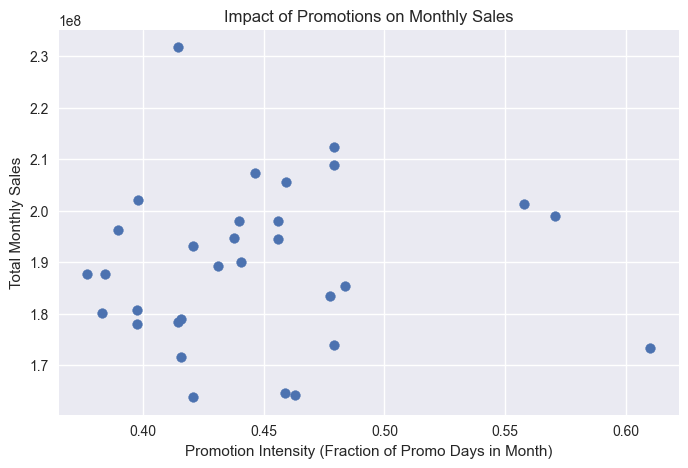

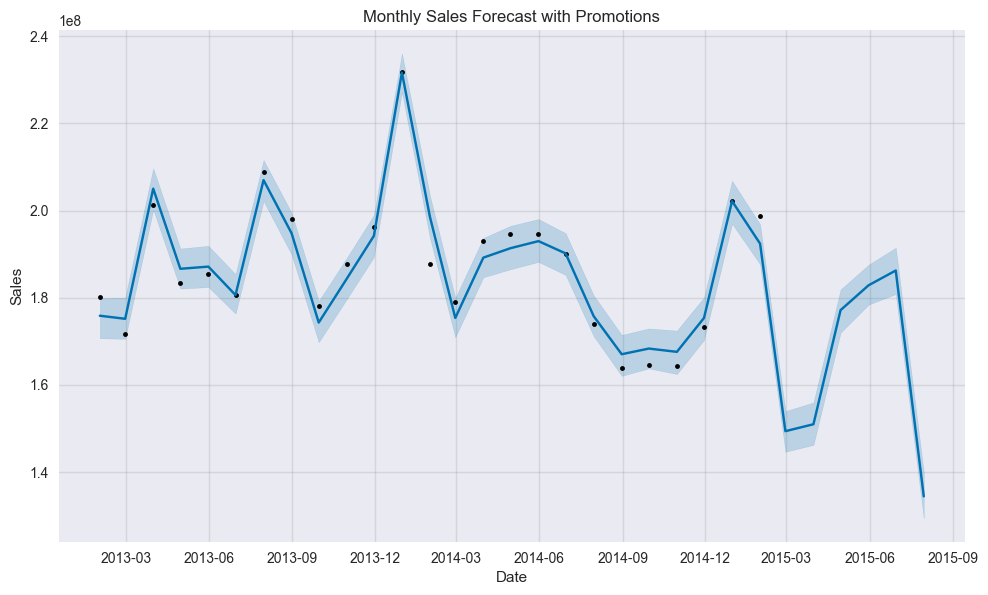

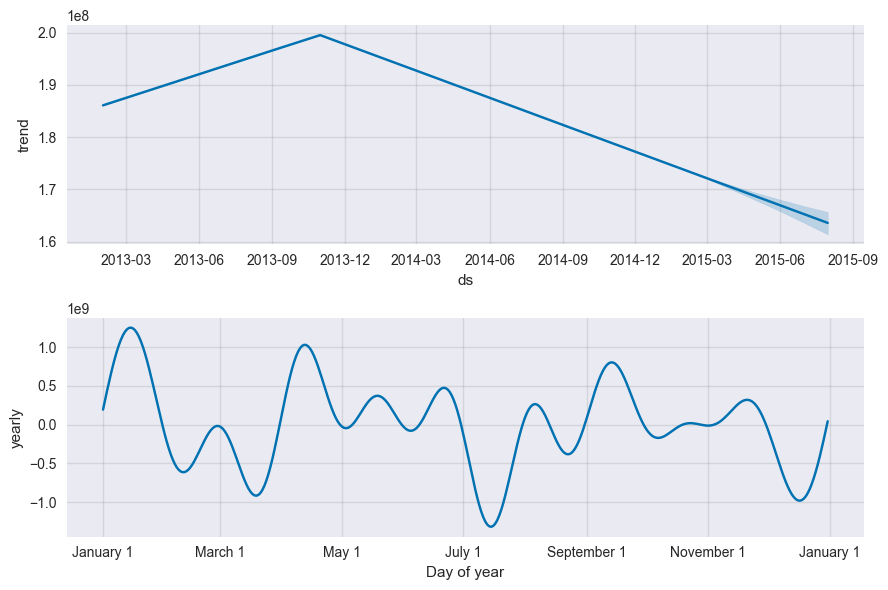

In [26]:
# Create future dataframe for evaluation period
promo_future = promo_eval_model.make_future_dataframe(
    periods=promo_test_period,
    freq="M"
)

# Merge promo values using date to ensure alignment
promo_future = promo_future.merge(
    monthly_sales_promo[["ds", "Promo"]],
    on="ds",
    how="left"
)

# Verify that no Promo values are missing
promo_future["Promo"] = promo_future["Promo"].fillna(
    monthly_sales_promo["Promo"].mean()
)

# Generate forecast
promo_forecast_test = promo_eval_model.predict(promo_future)

# Extract predictions for test period
promo_predicted = promo_forecast_test.tail(promo_test_period)["yhat"].values
promo_actual = promo_test_df["y"].values


# Compute evaluation metrics
promo_mape = mean_absolute_percentage_error(promo_actual, promo_predicted)
promo_rmse = np.sqrt(mean_squared_error(promo_actual, promo_predicted))

print(f"Monthly MAPE with Promotions: {promo_mape:.4f}")
print(f"Monthly RMSE with Promotions: {promo_rmse:.2f}")

# Visualize relationship between promotion intensity and sales
plt.figure(figsize=(8, 5))
plt.scatter(
    monthly_sales_promo["Promo"],
    monthly_sales_promo["y"]
)
plt.xlabel("Promotion Intensity (Fraction of Promo Days in Month)")
plt.ylabel("Total Monthly Sales")
plt.title("Impact of Promotions on Monthly Sales")
plt.show()

# Plot forecast with historical monthly sales
promo_eval_model.plot(monthly_forecast_test)
plt.title("Monthly Sales Forecast with Promotions")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()
# Plot model components
promo_eval_model.plot_components(monthly_forecast_test)
plt.show()


### Final Model Evaluation Summary

The monthly forecasting model with promotions as an external regressor achieves
a MAPE of approximately 12.2%, representing the best performance among all
models tested. This confirms that combining noise reduction through monthly
aggregation with domain knowledge in the form of promotional activity leads to
more accurate and stable forecasts.

This model is well-suited for strategic sales planning and decision-making at
a monthly level.
